In [29]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

import torchvision

In [30]:
train_loader = DataLoader(
    torchvision.datasets.MNIST("./data/datasets", train=True, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=64, shuffle=False
)

test_loader = DataLoader(
    torchvision.datasets.MNIST("./data/datasets", download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=64, shuffle=False
)

In [31]:
class CrappyNet(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 5, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(5, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(10 * (img_size[0] // 2) * (img_size[1] // 2), 10)
        )
        
    def forward(self, imgs):
        N,C,H,W = imgs.shape
        features = self.conv(imgs)
        logits = self.fc(features.view(N, -1))
        return logits
    
    def nll(self, imgs, labels):
        labels = torch.unsqueeze(labels, 1)
        logits = self(imgs)
        probs = F.softmax(logits, dim=1)
        nlog_probs = -torch.log(probs.gather(1, labels))
        return nlog_probs.sum()
    
    def predict_labels(self, imgs):
        with torch.no_grad():
            logits = self(imgs)
            _, labels = logits.max(1)
        return labels

In [32]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for imgs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        loss = model.nll(imgs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses
        
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            loss = model.nll(imgs, labels)
            test_loss += loss.item() * len(labels)
    return test_loss / len(test_loader.dataset)

def percentace_correct(model, test_loader):
    model.eval()
    num_correct = 0
    for imgs, labels in test_loader:
        predicted_labels = model.predict_labels(imgs)
        num_correct += (labels == predicted_labels).sum()
    return num_correct / len(test_loader.dataset)
        
def train_epochs(model, train_loader, test_loader, train_args):
    lr = train_args["lr"]
    epochs = train_args["epochs"]
    optimizer = Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = [test(model, test_loader)]
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_losses.extend(train(model, train_loader, optimizer))
        test_losses.append(test(model, test_loader))
    return train_losses, test_losses 

In [33]:
_,H,W= train_loader.dataset[0][0].shape

model = CrappyNet((H, W))

train_args = {'lr': 1e-3, 'epochs': 2}
train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)

epoch: 1


100%|██████████| 938/938 [00:44<00:00, 20.95it/s]


epoch: 2


100%|██████████| 938/938 [00:42<00:00, 22.18it/s]


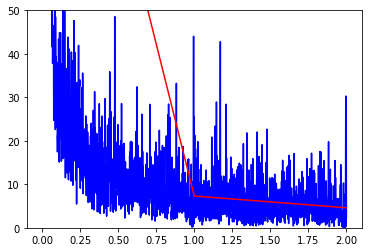

Final Train Loss: 2.3025598526000977
Final Test Loss: 4.616881072163582
Percentage Correct: 0.9773333072662354


In [34]:
# len(train_losses) = number of training iteration
#                   = number of epochs * number of training steps per epoch
# len(test_losses) = number of epochs + 1
def plot_losses(train_losses, test_losses):
    epochs = len(test_losses) - 1
    steps_per_epoch = len(train_losses) / epochs
    train_losses_epochs = [((i+1)/steps_per_epoch) for i in range(len(train_losses))]
    test_losses_epochs = [i for i in range(len(test_losses))]
    plt.plot(train_losses_epochs, train_losses, color="blue")
    plt.plot(test_losses_epochs, test_losses, color="red")
    plt.ylim([0, 50])
    plt.show()
    
plot_losses(train_losses, test_losses)
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Final Test Loss: {test_losses[-1]}")
print(f"Percentage Correct: {percentace_correct(model, test_loader)}")